In [46]:
import kagglehub
import os
import cv2

from sklearn.preprocessing import OneHotEncoder
import numpy as np
from PIL import Image

# Download latest version
path = kagglehub.dataset_download("esmanurdeli/scooby-doo-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/esmanurdeli/scooby-doo-classification-dataset/versions/1


In [47]:
path+='/dataset'

In [48]:
folders = os.listdir(path)

In [49]:
hog = cv2.HOGDescriptor()

In [50]:
tags = np.array(folders).reshape(-1, 1)

In [51]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(tags)

OneHotEncoder(sparse_output=False)

In [93]:
characters = {}

In [99]:
# Extraer características HOG
def extract_hog_features(folders, path):
    features = []
    labels = []

    hog = cv2.HOGDescriptor()  # Definir HOG Descriptor

    for index, folder in enumerate(reversed(folders)):
        imgs = os.listdir(os.path.join(path, folder))

        characters[index] = folder

        for img in imgs:
            labels.append(folder)
            image_path = os.path.join(path, folder, img)

            # Leer y normalizar imagen
            normalized_img = read_image(image_path)

            # 🔴 Convertir a escala de grises (HOG trabaja mejor en grayscale)
            gray_img = cv2.cvtColor(normalized_img, cv2.COLOR_RGB2GRAY)

            # Extraer características HOG
            hog_features = hog.compute(gray_img)

            features.append(hog_features.flatten())

    return features, labels

In [100]:
# Leer y normalizar la imagen
def read_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (128, 128))  # Redimensionar para HOG
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

    pixels = np.asarray(image, dtype=np.float32)

    # Calcular media y desviación estándar por canal
    mean = pixels.mean(axis=(0,1))
    std = pixels.std(axis=(0,1))

    # Normalizar por canal
    normalized_pixels = (pixels - mean) / std

    # 🔴 Convertir a uint8 (HOG lo requiere en [0, 255])
    normalized_pixels = (normalized_pixels * 255).clip(0, 255).astype(np.uint8)

    return normalized_pixels

In [101]:
imgs, labels = extract_hog_features(folders, path)

In [103]:
print(len(imgs))
print(len(labels))

221
221


In [104]:
characters

{0: 'Daphne', 1: 'Fred', 2: 'Scooby', 3: 'Shaggy', 4: 'Velma'}

In [109]:
labels = np.array([labels]).reshape(-1, 1)
labels = encoder.transform(labels)

In [110]:
# Función para entrenar un SVM
def train_svm(features, labels):
    svm = cv2.ml.SVM_create()
    svm.setKernel(cv2.ml.SVM_LINEAR)
    svm.setType(cv2.ml.SVM_C_SVC)
    svm.setC(1.0)

    print(f"Features shape: {features.shape}")  # Debe ser (n_samples, num_features)
    print(f"Labels shape: {labels.shape}")  # Debe ser (n_samples, 1)

    svm.train(features.astype(np.float32), cv2.ml.ROW_SAMPLE, labels)
    return svm

In [111]:
imgs = np.array(imgs, dtype=np.float32)

In [113]:
numeric_labels = np.argmax(labels, axis=1).reshape(-1, 1).astype(np.int32)

In [114]:
numeric_labels

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [115]:
# Entrenar SVM
svm_model = train_svm(imgs, numeric_labels)

Features shape: (221, 34020)
Labels shape: (221, 1)


In [116]:
def predict_svm(svm, features):
    _, result = svm.predict(features.astype(np.float32))
    return result.flatten()

In [133]:
image_path = path+'/Shaggy/shaggy_40.jpeg'
image = read_image(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_descriptor = cv2.HOGDescriptor()
hog_features = hog_descriptor.compute(gray_image).flatten().reshape(1, -1)
prediction = predict_svm(svm_model, hog_features)

print(f"Prediction: {characters[int(prediction[0])]}")

Predicción: Shaggy


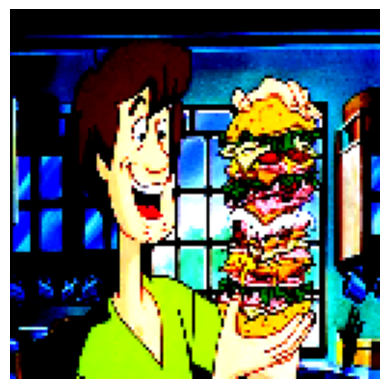

In [135]:
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

image = read_image(image_path)
show_image(image)